In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from scipy.stats import binned_statistic, powerlaw
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.integrate import quad
from astropy.io import fits, ascii
import kmeans_radec
import Setup as p

import scipy.constants

417067
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


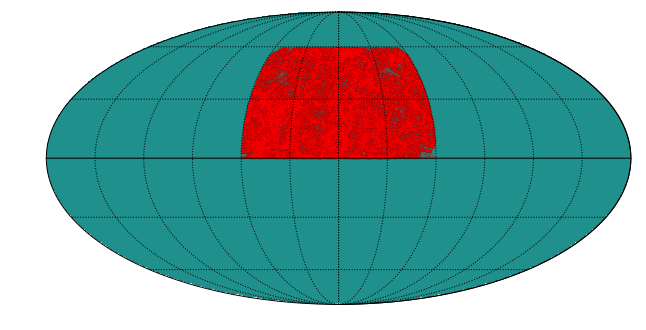

In [2]:
h = 0.688
catalog = fits.open("../../BAM/Old/nsa_v1.fits")[1].data

# Remove objects without mass estimate
MS = catalog['SERSIC_MASS']
IDS = np.where(np.isfinite(MS))

logMS = np.log10(MS[IDS]-2*np.log10(h))
RA = catalog['RA'][IDS]
DEC = catalog['DEC'][IDS]
# Try using redshifts for Corrfunc instead of co-moving distances
CZ = catalog['ZDIST'][IDS]*scipy.constants.c*1e-3
absmag = catalog['SERSIC_ABSMAG'][:, 4][IDS]-5*np.log10(h)

# Remove objects without absmag estimate
IDS = np.where(np.isfinite(absmag))
logMS = logMS[IDS]
RA = RA[IDS]
DEC = DEC[IDS]
CZ = CZ[IDS]
absmag = absmag[IDS]

IDS = np.where(np.logical_and(DEC > 0, DEC < 60))
logMS = logMS[IDS]
RA = RA[IDS]
DEC = DEC[IDS]
CZ = CZ[IDS]
absmag = absmag[IDS]

IDS = np.where(np.logical_and(RA < 240, RA > 120))
logMS = logMS[IDS]
RA = RA[IDS]
DEC = DEC[IDS]
CZ = CZ[IDS]
absmag = absmag[IDS]

IDS = np.where(logMS > 6)
logMS = logMS[IDS]
RA = RA[IDS]
DEC = DEC[IDS]
CZ = CZ[IDS]
absmag = absmag[IDS]

print(CZ.size)

hp.mollview(np.zeros(12), rot=180, cbar=False, title='')
hp.graticule()
hp.projscatter(np.pi/2-np.deg2rad(DEC), np.deg2rad(RA), s=0.001, c='red')
plt.show()

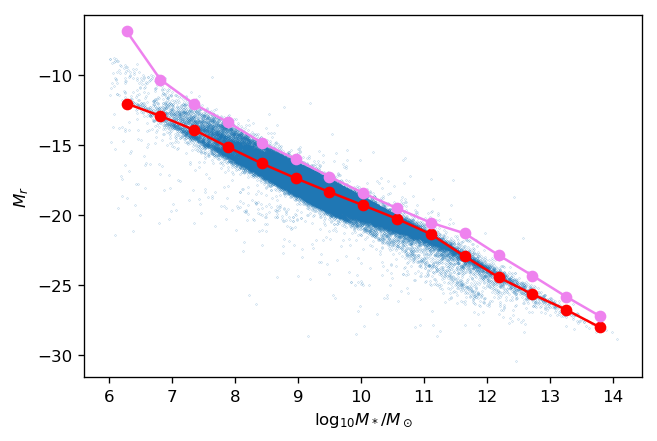

In [3]:
stat, bin_edges, __ = binned_statistic(logMS, absmag, bins=15)
statstd, bin_edges, __ = binned_statistic(logMS, absmag, bins=15, statistic=np.std)
bin_centers = p.bin_centers(bin_edges)

upperbound = stat+2*statstd

MS2absmag_func = interp1d(bin_centers, upperbound)

plt.figure(dpi=120)
plt.scatter(logMS, absmag, s=0.01)
plt.plot(bin_centers, stat, c='red', marker='o')
plt.plot(bin_centers, upperbound, c='violet', marker='o')
plt.xlabel(r"$\log_{10}M_*/M_\odot$")
plt.ylabel(r"$M_r$")
plt.show()

-19.171712357384447


/mnt/zfsusers/rstiskalek/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


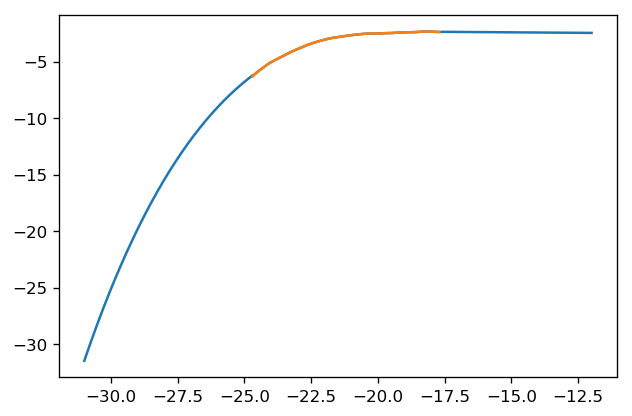

In [30]:
# Calculate the SDSS survival function
dataLF = np.loadtxt("../../Data/SMmatching/LF_Ser.dat")

xLF = dataLF[:, 0]
yLF = dataLF[:, 1]

# Interpolate the galaxy luminosity function
nlum = interp1d(xLF, yLF, kind='cubic')
t = np.linspace(xLF.min(), xLF.max(), 1000)

# Extrapolate the faint and bright end
def bright_end_func(x, a, b, c, d):
    return -np.exp(a*x+b) + c*x + d

def faint_end_func(x, a, b):
    return a*x+b

bright_end_coef = curve_fit(bright_end_func, xLF[:27], yLF[:27], [[1, 0, 0, 0]], maxfev=100000)[0]
s = slice(-5, None)
faint_end_coef = curve_fit(faint_end_func, xLF[s], yLF[s], [0, 0], maxfev=100000)[0]


tbright = np.linspace(-24.7, -31, 250)
a, b, c, d = bright_end_coef
ybright = [bright_end_func(i, a, b, c, d) for i in tbright]

tfaint=np.linspace(-17.6, -12, 250)
a, b = faint_end_coef
yfaint = [faint_end_func(i, a, b) for i in tfaint]

y = nlum(t)

# Merge the arrays
xx = np.hstack([tfaint, t, tbright])
yy = np.hstack([yfaint, y, ybright])

IDS = np.argsort(xx)
xx = xx[IDS]
yy = yy[IDS]

IDS = np.unique(xx, return_index=True)[1]
xx = xx[IDS]
yy = yy[IDS]
# Extrapolated luminosity function
nlum = interp1d(xx, 10**yy, kind='cubic')

def func_absmag(appmag, d):
    # Distance in Mpc
    return appmag-25-5*np.log10(d)


logMSlim = 10.4



faintest_absmag = MS2absmag_func(logMSlim)
brightest_absmag = np.min(absmag)
print(faintest_absmag)

plt.figure(dpi=120)
plt.plot(xx, yy)
plt.plot(xLF, yLF)
plt.show()

In [31]:
def survival_func_SM(dist_arr, faintest_absmag):
    norm = quad(nlum, faintest_absmag, brightest_absmag)[0]

    y = list()
    for d in dist_arr:
        sdsslim = func_absmag(17.6, d)
        # If SDSS lim is less bright than faintest sdss object return 1.0
        if sdsslim > faintest_absmag:
            y.append(1.0)
        else:
            integ = quad(nlum, sdsslim, brightest_absmag, limit=100, epsabs=1.49e-5)
            if integ[1] > 1e-3:
                print("Hmm, having problems")
            y.append(integ[0]/norm)

    return interp1d(dist_arr, y, kind='cubic')

In [32]:
def redshift2distance(z):
    omega_m = 0.295
    omega_lambda = 0.705
    omega_k = 0.0
    H0 = 68.8
    Dh = scipy.constants.c*1e-3/(H0)
    num = lambda z_prime : 1/np.sqrt(omega_m*(1+z_prime)**3+omega_k*(1+z_prime)**2+omega_lambda)
    quadnum = quad(num, 0, z)[0]
    comoving_distance = Dh*quadnum
    return comoving_distance
    

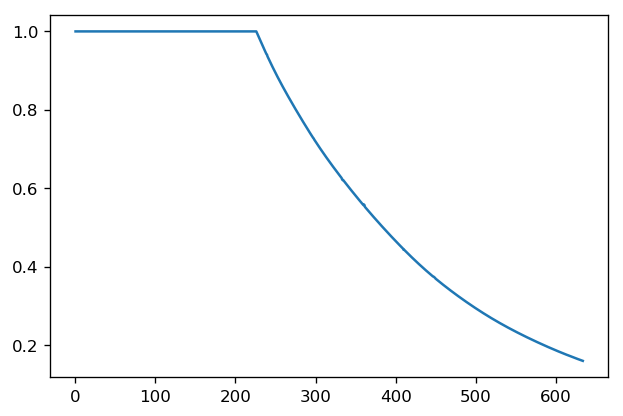

In [33]:
mindist = redshift2distance(CZ.min()/(scipy.constants.c*1e-3))
maxdist = redshift2distance(CZ.max()/(scipy.constants.c*1e-3))

dist_arr = np.linspace(mindist, maxdist, 1000)
y_func = survival_func_SM(dist_arr, faintest_absmag)
y = y_func(dist_arr)

surv_func = interp1d(dist_arr, y, bounds_error=False, fill_value='extrapolate')

plt.figure(dpi=120)
plt.plot(dist_arr,y)
plt.show()

Done generating randoms
Done with clustering.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
20000000
7416121


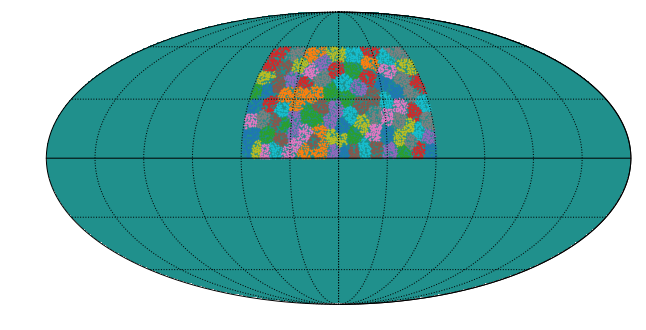

In [34]:
# Generate a random catalog
Nrands = int(2e7)
RAmin, RAmax = np.deg2rad(RA.min()), np.deg2rad(RA.max())
Pmin = (np.sin(np.deg2rad(DEC.min()))+1)/2
Pmax = (np.sin(np.deg2rad(DEC.max()))+1)/2
CZmin, CZmax = CZ.min(), CZ.max()

randRA = np.rad2deg(np.random.uniform(RAmin, RAmax, Nrands))
randDEC = np.rad2deg(np.arcsin(2*np.random.uniform(Pmin, Pmax, size=Nrands)-1))
randCZ = powerlaw.rvs(a=3, loc=CZmin, scale=CZmax-CZmin, size=Nrands)
print("Done generating randoms")

# Cluster the galaxies for jackknifing
N = randRA.size
Ncluster = 10000
IDS = np.random.choice(np.arange(N), Ncluster, False)
X = np.vstack([randRA[IDS], randDEC[IDS]]).T
km = kmeans_radec.kmeans_sample(X, p.ncent, maxiter=250, tol=1.0e-5, verbose=0)

X = np.vstack([randRA, randDEC]).T
randLabels = km.find_nearest(X)
print("Done with clustering.")

hp.mollview(np.zeros(12), rot=180, title='', cbar=False)
hp.graticule()
for label in np.unique(km.labels):
    IDSlab = np.where(km.labels==label)
    hp.projscatter(np.pi/2-np.deg2rad(randDEC[IDS][IDSlab]), np.deg2rad(randRA[IDS][IDSlab]), s=0.5)
    
# # Apply selection effects to the rand.
randdist = np.array([redshift2distance(cz/(scipy.constants.c*1e-3)) for cz in randCZ])
N = randdist.size
print(N)


prob_arr = surv_func(randdist)
rand_arr = np.random.uniform(0, 1, N)

IDS = np.where((prob_arr-rand_arr) > 0)
randdist = randdist[IDS]
randCZ = randCZ[IDS]
randRA = randRA[IDS]
randDEC = randDEC[IDS]
randLabels = randLabels[IDS]
print(randdist.size)

We have 7416121 galaxies in random with cut at 10.4.
We have 155221 galaxies in observation.


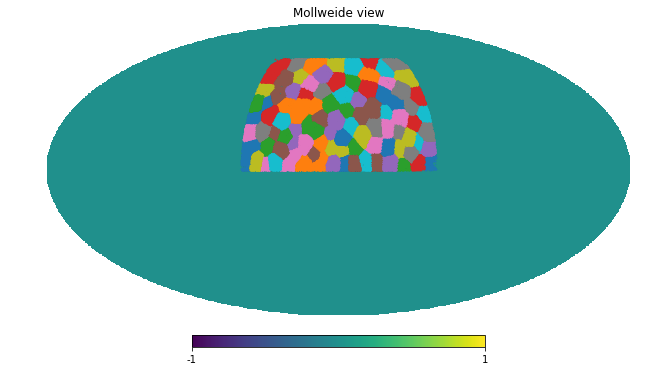

In [35]:
N = randCZ.size
random_catalog = np.zeros(N, dtype={'names':('ra', 'dec', 'cz', 'label', 'weights'),
                                'formats':('float64', 'float64', 'float64', 'int64', 'float64')})
random_catalog['ra'] = randRA
random_catalog['dec'] = randDEC
random_catalog['cz'] = randCZ
random_catalog['label'] = randLabels
random_catalog['weights'] = np.ones_like(randRA)
# random_catalog['weights'] = get_weights(randdist)

np.save("../../Data/NSAmatching/CFrandcatNSa_{}_.npy".format(logMSlim), random_catalog)
print("We have {} galaxies in random with cut at {}.".format(N, logMSlim))

IDS = np.where(logMS>logMSlim)
N = CZ[IDS].size
X = np.vstack([RA[IDS], DEC[IDS]]).T

cut_catalog = np.zeros(N, dtype={'names':('ra', 'dec', 'cz', 'weights', 'label'),
                                'formats':('float64', 'float64', 'float64', 'float64', 'int64')})
cut_catalog['ra'] = RA[IDS]
cut_catalog['dec'] = DEC[IDS]
cut_catalog['cz'] = CZ[IDS]
# cut_catalog['weights'] = get_weights(dist[IDS])
cut_catalog['label'] = km.find_nearest(X)
cut_catalog['weights'] = np.ones_like(RA[IDS])

np.save("../../Data/NSAmatching/CFcatNSA_{}_.npy".format(logMSlim), cut_catalog)
print("We have {} galaxies in observation.".format(N))

hp.mollview(np.zeros(12), rot=180)
for label in np.unique(km.labels):
    IDSlab = np.where(label==cut_catalog['label'])
    hp.projscatter(np.pi/2-np.deg2rad(DEC[IDS])[IDSlab], np.deg2rad(RA[IDS])[IDSlab], s=0.5)
    